
# PredictionTask — Basics

This notebook gives a minimal, **teaching-style** walkthrough of the `PredictionTask`:
- define a simple generator that emits a sequence of values,
- define a simple agent that places binary bets,
- run the task and inspect logs,
- plot the cumulative reward trajectory.

> The examples here are **domain-agnostic** and self-contained. You can swap in your own generator/agent later.


In [22]:

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Import from your package
from tsdm.tasks import PredictionTask



## 1) Tiny demo components

We define two lightweight generators and two simple agents:

- `UpGenerator`: value increases by +1 each step.
- `RandomWalkGen`: value follows a simple drifted random walk.
- `AlwaysUpAgent`: always bets "up" (1).
- `MeanReversionAgent`: bets down if the last value is above its running mean, else up.


In [23]:

class UpGenerator:
    """Monotone increasing generator: v_t = v_{t-1} + 1"""
    def __init__(self):
        self.v = None
    def generate_value(self, last_value):
        if self.v is None:
            self.v = last_value
        self.v = self.v + 1.0
        return self.v

class RandomWalkGen:
    """Drifted random walk: v_t = v_{t-1} + drift + noise"""
    def __init__(self, drift=0.0, scale=1.0, seed=42):
        self.rng = np.random.default_rng(seed)
        self.drift = float(drift)
        self.scale = float(scale)
        self.v = None
    def generate_value(self, last_value):
        if self.v is None:
            self.v = last_value
        step = self.drift + self.rng.normal(0.0, self.scale)
        self.v = float(self.v + step)
        return self.v

class AlwaysUpAgent:
    """Always predicts 'up' (returns 1)."""
    def observe(self, value_prev):
        pass
    def place_bet(self):
        return 1

class MeanReversionAgent:
    """Bets down if last > running mean, else up."""
    def __init__(self):
        self.values = []
    def observe(self, value_prev):
        self.values.append(float(value_prev))
    def place_bet(self):
        if not self.values:
            return 1
        mean = float(np.mean(self.values))
        last = self.values[-1]
        return 0 if last > mean else 1



## 2) Run: Upward series + AlwaysUpAgent

Since the series increases by +1 each step, the `AlwaysUpAgent` should be correct every time.


In [24]:

gen = UpGenerator()
agent = AlwaysUpAgent()

task = PredictionTask(generator=gen, agent=agent, total_movements=20, start_value=0.0)
final_reward = task.play_game()

print(f"Final cumulative reward: {final_reward}")
print(f"Number of log entries: {len(task.log)}")
print("First 3 logs:")
for rec in task.log[:3]:
    print(rec)


Final cumulative reward: 20
Number of log entries: 20
First 3 logs:
{'t': 1, 'value_prev': 0.0, 'value': 1.0, 'bet': 1, 'received_reward': 1, 'reward_cum': 1}
{'t': 2, 'value_prev': 1.0, 'value': 2.0, 'bet': 1, 'received_reward': 1, 'reward_cum': 2}
{'t': 3, 'value_prev': 2.0, 'value': 3.0, 'bet': 1, 'received_reward': 1, 'reward_cum': 3}



### Plot cumulative reward


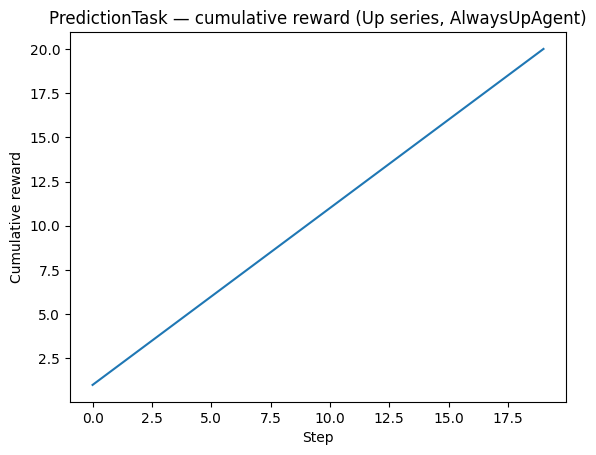

In [25]:

plt.figure()
plt.plot(task.reward_development)
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.title("PredictionTask — cumulative reward (Up series, AlwaysUpAgent)")
plt.show()



## 3) Run: RandomWalk + MeanReversionAgent

Here the behavior is less predictable, but we can still observe the logging structure and reward path.


In [26]:

gen2 = RandomWalkGen(drift=0.1, scale=0.5, seed=7)
agent2 = MeanReversionAgent()

task2 = PredictionTask(generator=gen2, agent=agent2, total_movements=100, start_value=0.0)
final_reward2 = task2.play_game()

print(f"Final cumulative reward (random walk): {final_reward2}")
print(f"Logged {len(task2.log)} steps")



Final cumulative reward (random walk): 2
Logged 100 steps



### Inspect a few log rows

Each log record is a dict with keys:
- `t`: 1-based step index
- `value_prev`: previous value
- `value`: new value
- `bet`: 0 or 1
- `received_reward`: +1 or -1
- `reward_cum`: cumulative reward after the step


In [27]:

for rec in task2.log[:5]:
    print(rec)


{'t': 1, 'value_prev': 0.0, 'value': 0.1006150766787413, 'bet': 1, 'received_reward': 1, 'reward_cum': 1}
{'t': 2, 'value_prev': 0.1006150766787413, 'value': 0.34998784543297623, 'bet': 0, 'received_reward': -1, 'reward_cum': 0}
{'t': 3, 'value_prev': 0.34998784543297623, 'value': 0.3129189177518674, 'bet': 0, 'received_reward': 1, 'reward_cum': 1}
{'t': 4, 'value_prev': 0.3129189177518674, 'value': -0.03237700162676971, 'bet': 0, 'received_reward': 1, 'reward_cum': 2}
{'t': 5, 'value_prev': -0.03237700162676971, 'value': -0.15971239421263098, 'bet': 1, 'received_reward': -1, 'reward_cum': 1}



### Plot cumulative reward for the random walk


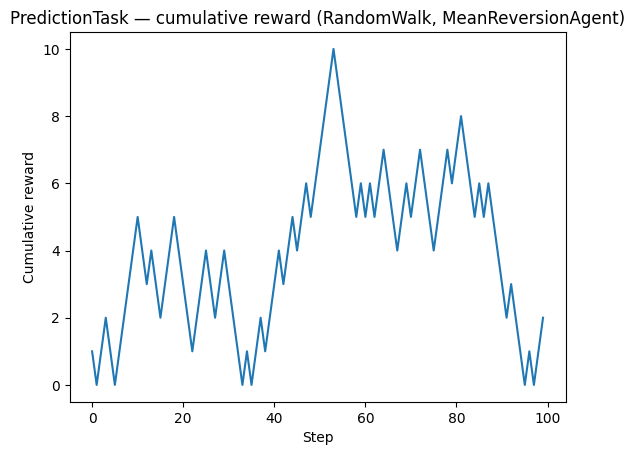

In [28]:

plt.figure()
plt.plot(task2.reward_development)
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.title("PredictionTask — cumulative reward (RandomWalk, MeanReversionAgent)")
plt.show()



## 4) Tips for extending

- Swap in your own **generator** with a `.generate_value(last_value)` method.
- Build smarter **agents** using the `observe()` memory (e.g., rolling stats, ML models).
- Convert `task.log` to a DataFrame for analysis.
- For experiments, seed your RNGs for reproducibility.
